In [19]:
!python -V

Python 3.9.12


In [20]:
import pandas as pd

In [21]:
import pickle

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge

from sklearn.metrics import mean_squared_error

In [24]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

In [7]:
df.describe()

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,76518.000000,40471.000000,76518.000000,76518.000000,40471.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,40471.000000,40471.000000,40471.000000
mean,1.905290,1.143041,109.590371,130.685577,1.192311,40.862552,19.939777,0.740462,0.254104,1.506499,0.546209,0.298142,23.574820,1.406958,1.030590,0.613828
std,0.292816,0.878693,71.063053,77.101641,0.756395,1924.408778,14.984241,1.184429,0.251467,1.877930,1.876162,0.029243,16.361991,0.517005,0.172206,1.145076
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,-280.000000,-5.500000,-0.500000,-9.450000,0.000000,-0.300000,-280.300000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,55.000000,65.000000,1.000000,1.300000,9.000000,0.000000,0.000000,0.000000,0.000000,0.300000,11.800000,1.000000,1.000000,0.000000
50%,2.000000,1.000000,76.000000,129.000000,1.000000,2.590000,16.730000,0.000000,0.500000,1.160000,0.000000,0.300000,20.640000,1.000000,1.000000,0.000000
75%,2.000000,1.000000,166.000000,197.000000,1.000000,5.760000,25.500000,1.000000,0.500000,2.750000,0.000000,0.300000,29.320000,2.000000,1.000000,0.000000
max,2.000000,99.000000,265.000000,265.000000,8.000000,244152.010000,284.000000,8.250000,0.500000,110.000000,31.250000,0.300000,294.510000,5.000000,2.000000,2.750000


In [25]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [27]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred)

95.55970720911512

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


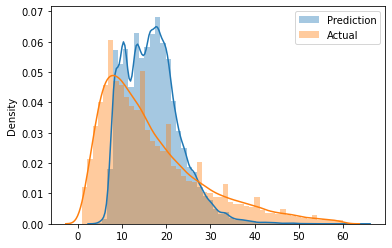

In [28]:
sns.distplot(y_pred, label='Prediction')
sns.distplot(y_train, label='Actual')

plt.legend()

In [29]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [30]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [31]:
df_train.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'duration'],
      dtype='object')

In [32]:
len(df_train), len(df_val)

(73908, 61921)

In [33]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [34]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)


In [35]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [36]:
X_val.shape, X_train.shape

((61921, 13221), (73908, 13221))

In [37]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred)

55.94385011743112

In [39]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [ ]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)